<a href="https://colab.research.google.com/github/sxergiu/fac-year-3/blob/main/IPR/IPR3_Laboratory_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Visualization of attention

As usual, we start with the necessary imports and set a constant seed for the random number generator in PyTorch.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import os
import requests
import zipfile
import collections

torch.manual_seed(42);

Average pooling can be treated as a weighted average of inputs, where weights are uniform. In practice, *attention pooling* aggregates values using weighted average, where weights are computed between the given query and different keys.

To visualize attention weights, we define the `show_heatmaps()` function. Its input `matrices` has the shape (number of rows for display, number of columns for display, number of queries, number of keys).

In [ ]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """Show heatmaps of matrices."""
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize,
                             sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

For demonstration, we consider a simple case where the attention weight is one only when the query and the key are the same; otherwise it is zero.

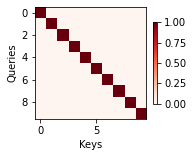

In [ ]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

# Attention pooling: Nadaraya-Watson kernel regression

Now, we generate an artificial dataset according to the following nonlinear function, with the noise term $\epsilon$:

$$y_i = 2\sin(x_i) + x_i^{0.8} + \epsilon,$$

where $\epsilon$ obeys a normal distribution with zero mean and standard deviation $0.5$. Both $50$ training examples and $50$ testing examples are generated. To better visualize the pattern of attention later, the training inputs are sorted.

In [ ]:
n_train = 50  # No. of training examples
x_train, _ = torch.sort(torch.rand(n_train) * 5)   # Training inputs

In [ ]:
def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # Training outputs
x_test = torch.arange(0, 5, 0.1)  # Testing examples
y_truth = f(x_test)  # Ground-truth outputs for the testing examples
n_test = len(x_test)  # No. of testing examples
n_test

50

The following function plots all the training examples (represented by circles), the ground-truth data generation function `f` without the noise term (labeled by "Truth"), and the learned prediction function (labeled by "Pred").

In [ ]:
def plot_kernel_reg(y_hat):
    plt.plot(x_test, y_truth, label='Truth')
    plt.plot(x_test, y_hat, label='Pred')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([0, 5])
    plt.ylim([-1, 5])
    plt.legend()
    plt.plot(x_train, y_train, 'o', alpha=0.5);

We begin with the world's "dumbest" estimator for this regression problem: using average pooling to average over all the training outputs:

$$f(x) = \frac{1}{n}\sum_{i=1}^n y_i,$$

which is plotted below. As we can see, this estimator is indeed not so smart.

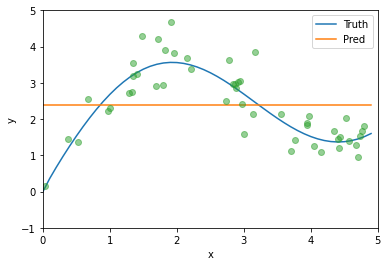

In [ ]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

In the following, we plot the prediction based on the Nadaraya-Watson kernel regression nonparametric attention model, given by:

$$f(x) =\sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}(x - x_i)^2\right) y_i.$$

The predicted line is smooth and closer to the ground-truth than that produced by average pooling.

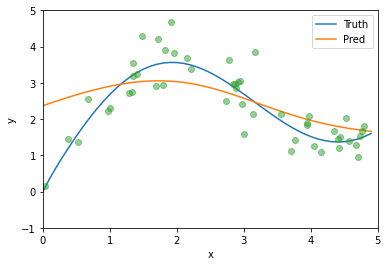

In [ ]:
# Shape of `X_repeat` is: (`n_test`, `n_train`), where each row contains the
# same testing inputs (i.e., same queries)
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# Note that `x_train` contains the keys. Shape of `attention_weights` is:
# (`n_test`, `n_train`), where each row contains attention weights to be
# assigned among the values (`y_train`), given each query
attention_weights = F.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# Each element of `y_hat` is a weighted average of values, where weights are
# attention weights
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

Now, let us take a look at the attention weights. Here, testing inputs are queries, while training inputs are keys. Since both inputs are sorted, we can see that the closer the query-key pair is, the higher the attention weight is in the attention pooling.

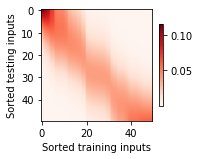

In [ ]:
show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
              xlabel='Sorted training inputs',
              ylabel='Sorted testing inputs')

We can also define the Nadaraya-Watson kernel regression parametric attention model by:

$$f(x) =\sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}((x - x_i)w)^2\right) y_i,$$

where $w$ is a learnable parameter. In the following, we will train this model by learning the $w$ parameter of the attention pooling.

To more efficiently compute attention for mini-batches, we can leverage the batch matrix multiplication utilities provided by PyTorch.

Suppose that the first mini-batch contains $n$ matrices $\boldsymbol{X}_1, \ldots, \boldsymbol{X}_n$ of shape $a\times b$, and the second mini-batch contains $n$ matrices $\boldsymbol{Y}_1, \ldots, \boldsymbol{Y}_n$ of shape $b\times c$. Their batch matrix multiplication results in $n$ matrices $\boldsymbol{X}_1\boldsymbol{Y}_1, \ldots, \boldsymbol{X}_n\boldsymbol{Y}_n$ of shape $a\times c$. Therefore, given two tensors of shape ($n$, $a$, $b$) and ($n$, $b$, $c$), the shape of their batch matrix multiplication output is ($n$, $a$, $c$).

In [ ]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

In the context of attention mechanisms, we can use mini-batch matrix multiplication to compute weighted averages of values in a mini-batch.

In [ ]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

Using mini-batch matrix multiplication, below we define the parametric version of Nadaraya-Watson kernel regression based on the parametric attention pooling defined above.

In [ ]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # Shape of the output `queries` and `attention_weights` is:
        # (no. of queries, no. of key-value pairs)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = F.softmax(-((queries - keys) * self.w)**2 / 2, dim=1)
        # Shape of `values` is: (no. of queries, no. of key-value pairs)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

In the following, we transform the training dataset to keys and values to train the attention model. In the parametric attention pooling, any training input takes key-value pairs from all the training examples except for itself, to predict its output.

In [ ]:
# Shape of `X_tile` is: (`n_train`, `n_train`), where each column contains the
# same training inputs
X_tile = x_train.repeat((n_train, 1))
# Shape of `Y_tile` is: (`n_train`, `n_train`), where each column contains the
# same training outputs
Y_tile = y_train.repeat((n_train, 1))
# Shape of `keys` is: ('n_train', 'n_train' - 1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# Shape of `values` is: ('n_train', 'n_train' - 1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

Using the squared loss and stochastic gradient descent, we train the parametric attention model.

In [ ]:
def plot_loss_regression(train_loss_all):
    epochs = range(1, len(train_loss_all) + 1)
    plt.plot(epochs, train_loss_all, 'b', label='Train loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

epoch 1, loss 42.404827
epoch 2, loss 22.872175
epoch 3, loss 22.793999
epoch 4, loss 22.713430
epoch 5, loss 22.630474


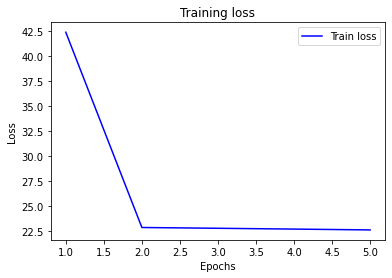

In [ ]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=0.5)

train_loss_all = []
for epoch in range(5):
    optimizer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    optimizer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    train_loss_all.append(float(l.sum()))

plot_loss_regression(train_loss_all)

After training the parametric attention model, we can plot its prediction. Trying to fit the training dataset with noise, the predicted line is less smooth
than its nonparametric counterpart that was plotted earlier.

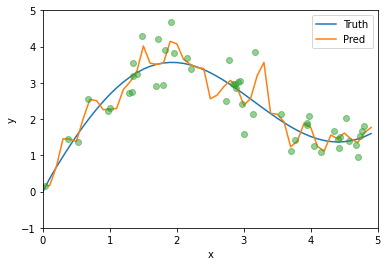

In [ ]:
# Shape of `keys` is: (`n_test`, `n_train`), where each column contains the same
# training inputs (i.e., same keys)
keys = x_train.repeat((n_test, 1))
# Shape of `value` is: (`n_test`, `n_train`)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

Comparing with nonparametric attention pooling, the region with large attention weights becomes sharper in the learnable and parametric setting.

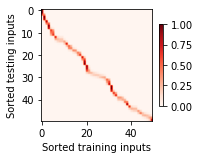

In [ ]:
show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
              xlabel='Sorted training inputs',
              ylabel='Sorted testing inputs')

# Attention scoring functions

A softmax operation is used to output a probability distribution as attention weights. In some cases, not all the values should be fed into attention pooling.
For instance, for efficient mini-batch processing, some text sequences are padded with special tokens that do not carry meaning. To get an attention pooling over only meaningful tokens as values, we can specify a valid sequence length (in number of tokens) to filter out those beyond this specified range,
when computing softmax. In this way, we can implement such a *masked softmax operation* in the following `masked_softmax()` function, where any value beyond the valid length is masked as zero. The `sequence_mask()` function is the same as in *Laboratory 5*.

In [ ]:
def sequence_mask(X, valid_len, value=0):
    """Mask irrelevant entries in sequences."""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

In [ ]:
def masked_softmax(X, valid_lens):
    """Perform softmax operation by masking elements on the last axis."""
    # `X`: 3D tensor, `valid_lens`: 1D or 2D tensor
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                          value=-1e6)
        return F.softmax(X.reshape(shape), dim=-1)

To demonstrate how this function works, consider a mini-batch of two $2 \times 4$ matrix examples, where the valid lengths for these two examples are two and three, respectively. As a result of the masked softmax operation, values beyond the valid lengths are all masked as zero.

In [ ]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.4441, 0.5559, 0.0000, 0.0000],
         [0.4622, 0.5378, 0.0000, 0.0000]],

        [[0.3300, 0.3723, 0.2977, 0.0000],
         [0.2507, 0.4257, 0.3236, 0.0000]]])

Similarly, we can also use a two-dimensional tensor to specify valid lengths for every row in each matrix example.

In [ ]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.2288, 0.4340, 0.3372, 0.0000]],

        [[0.3140, 0.6860, 0.0000, 0.0000],
         [0.2026, 0.2363, 0.2733, 0.2878]]])

Given a query $\mathbf{q} \in \mathbb{R}^q$ and a key $\mathbf{k} \in \mathbb{R}^k$, the *additive attention* scoring function is defined as:

$$a(\mathbf q, \mathbf k) = \mathbf w_v^\top \text{tanh}(\mathbf W_q\mathbf q + \mathbf W_k \mathbf k) \in \mathbb{R},$$

where the parameters $\mathbf W_q\in\mathbb R^{h\times q}$, $\mathbf W_k\in\mathbb R^{h\times k}$, and $\mathbf w_v\in\mathbb R^{h}$ are learnable.
This can be implemented by concatenating the query and the key, and feeding the result into an MLP with a single hidden layer whose number of hidden units is $h$, a hyperparameter. By using $\tanh$ as the activation function and disabling
bias terms, we implement additive attention in the following.

In [ ]:
class AdditiveAttention(nn.Module):
    """Additive attention."""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # After dimension expansion, shape of `queries` is: (`batch_size`, no.
        # of queries, 1, `num_hiddens`) and shape of `keys` is: (`batch_size`,
        # 1, no. of key-value pairs, `num_hiddens`). Sum them up with
        # broadcasting
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # There is only one output of `self.w_v`, so we remove the last
        # one-dimensional entry from the shape. Shape of `scores` is:
        # (`batch_size`, no. of queries, no. of key-value pairs)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # Shape of `values` is: (`batch_size`, no. of key-value pairs, value
        # dimension)
        return torch.bmm(self.dropout(self.attention_weights), values)

Let us demonstrate the above `AdditiveAttention` class with a toy example, where shapes (batch size, number of steps or sequence length in tokens, feature size) of queries, keys, and values are ($2$, $1$, $20$), ($2$, $10$, $2$), and ($2$, $10$, $4$), respectively. The attention pooling output has a shape of (batch size, number of steps for queries, feature size for values).

In [ ]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# The two value matrices in the `values` mini-batch are identical
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(
    2, 1, 1)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                              dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

Although additive attention contains learnable parameters, since every key is the same in this example, the attention weights are uniform, determined by the specified valid lengths.

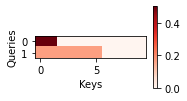

In [ ]:
show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
              xlabel='Keys', ylabel='Queries')

The *scaled dot-product attention*
of queries $\mathbf Q\in\mathbb R^{n\times d}$,
keys $\mathbf K\in\mathbb R^{m\times d}$,
and values $\mathbf V\in\mathbb R^{m\times v}$
is:

$$ \mathrm{softmax}\left(\frac{\mathbf Q \mathbf K^\top }{\sqrt{d}}\right) \mathbf V \in \mathbb{R}^{n\times v}.$$

In the following implementation of the scaled dot product attention, we use dropout for model regularization.

In [ ]:
class DotProductAttention(nn.Module):
    """Scaled dot product attention."""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # Shape of `queries` is: (`batch_size`, no. of queries, `d`)
    # Shape of `keys` is: (`batch_size`, no. of key-value pairs, `d`)
    # Shape of `values` is: (`batch_size`, no. of key-value pairs, value
    # dimension)
    # Shape of `valid_lens`: (`batch_size`,) or (`batch_size`, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Use `keys.transpose(1,2)` to swap the last two dimensions of `keys`
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

To demonstrate the above `DotProductAttention` class, we use the same keys, values, and valid lengths from the earlier toy example for additive attention. For the dot product operation, we make the feature size of queries the same as that of keys.

In [ ]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

Same as in the additive attention demonstration, since `keys` contains the same element that cannot be differentiated by any query, uniform attention weights are obtained.

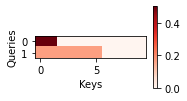

In [ ]:
show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
              xlabel='Keys', ylabel='Queries')

# Bahdanau attention

To implement the RNN encoder-decoder with *Bahdanau attention*, we only need to redefine the decoder. To visualize the learned attention weights more conveniently, the following `AttentionDecoder` class defines the base interface for decoders with attention mechanisms. The `Decoder` class is the same as in *Laboratory 5*.

In [ ]:
class Decoder(nn.Module):
    """The base decoder interface for the encoder-decoder architecture."""
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

In [ ]:
class AttentionDecoder(Decoder):
    """The base attention-based decoder interface."""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)

    @property
    def attention_weights(self):
        raise NotImplementedError

Now, let us implement the RNN decoder with Bahdanau attention in the following `Seq2SeqAttentionDecoder` class. The state of the decoder is initialized with
(i) the encoder final-layer hidden states at all the time steps (as keys and values of the attention);
(ii) the encoder all-layer hidden state at the final time step (to initialize the hidden state of the decoder);
and (iii) the encoder valid length (to exclude the padding tokens in attention pooling).
At each decoding time step, the decoder final-layer hidden state at the previous time step is used as the query of the attention. As a result, both the attention output and the input embedding are concatenated as the input of the RNN decoder.

In [ ]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = AdditiveAttention(
            num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # Shape of `outputs` is: (`num_steps`, `batch_size`, `num_hiddens`).
        # Shape of `hidden_state[0]` is: (`num_layers`, `batch_size`,
        # `num_hiddens`)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # Shape of `enc_outputs` is: (`batch_size`, `num_steps`, `num_hiddens`).
        # Shape of `hidden_state[0]` is: (`num_layers`, `batch_size`,
        # `num_hiddens`)
        enc_outputs, hidden_state, enc_valid_lens = state
        # Shape of the output `X` is: (`num_steps`, `batch_size`, `embed_size`)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # Shape of `query` is: (`batch_size`, 1, `num_hiddens`)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # Shape of `context` is: (`batch_size`, 1, `num_hiddens`)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            # Concatenate on the feature dimension
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # Reshape `x` as (1, `batch_size`, `embed_size` + `num_hiddens`)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # After fully-connected layer transformation, shape of `outputs` is:
        # (`num_steps`, `batch_size`, `vocab_size`)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

In the following, we test the implemented decoder with Bahdanau attention using a mini-batch of $4$ sequence inputs of $7$ time steps. The `Encoder` and `Seq2SeqEncoder` classes are the same as in *Laboratory 5*.

In [ ]:
class Encoder(nn.Module):
    """The base encoder interface for the encoder-decoder architecture."""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError

class Seq2SeqEncoder(Encoder):
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X, *args):
        # The output `X` shape: (`batch_size`, `num_steps`, `embed_size`)
        X = self.embedding(X)
        # In RNN models, the first axis corresponds to time steps
        X = X.permute(1, 0, 2)
        # When state is not mentioned, it defaults to zeros
        output, state = self.rnn(X)
        # `output` shape: (`num_steps`, `batch_size`, `num_hiddens`)
        # `state` shape: (`num_layers`, `batch_size`, `num_hiddens`)
        return output, state

In [ ]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                             num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                                  num_layers=2)
decoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)  # (`batch_size`, `num_steps`)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

Similar to *Laboratory 5*, here we specify hyperparemeters, instantiate an encoder and a decoder with Bahdanau attention, and train this model for machine translation. Due to the newly added attention mechanism, this training is much slower than that in *Laboratory 5* without attention mechanisms. All the other functions and classes are the same as in *Laboratory 5*.

In [ ]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [ ]:
class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # The index for the unknown token is 0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # Index for the unknown token
        return 0

    @property
    def token_freqs(self):  # Token frequencies
        return self._token_freqs

def count_corpus(tokens):
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

def download(url, cache_dir=os.path.join('..', 'data')):
    """Download a file, return the local filename."""
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
        return fname
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(url, folder=None):
    """Download and extract a zip file."""
    fname = download(url)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    else:
        assert False, 'Only zip files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def read_data_nmt():
    """Load the English-French dataset."""
    data_dir = download_extract('http://d2l-data.s3-accelerate.amazonaws.com/fra-eng.zip')
    with open(os.path.join(data_dir, 'fra.txt'), 'r') as f:
        return f.read()

def preprocess_nmt(text):
    """Preprocess the English-French dataset."""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # Replace non-breaking space with space, and convert uppercase letters to
    # lowercase ones
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # Insert space between words and punctuation marks
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

def tokenize_nmt(text, num_examples=None):
    """Tokenize the English-French dataset."""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))  # Pad

def build_array_nmt(lines, vocab, num_steps):
    """Transform text sequences of machine translation into mini-batches."""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator."""
    dataset = torch.utils.data.TensorDataset(*data_arrays)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle=is_train)

def load_data_nmt(batch_size, num_steps, num_examples=600):
    """Return the iterator and the vocabularies of the translation dataset."""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

In [ ]:
class EncoderDecoder(nn.Module):
    """The base class for the encoder-decoder architecture."""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

In [ ]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """The softmax cross-entropy loss with masks."""
    # `pred` shape: (`batch_size`, `num_steps`, `vocab_size`)
    # `label` shape: (`batch_size`, `num_steps`)
    # `valid_len` shape: (`batch_size`,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

def grad_clipping(net, theta):
    """Clip the gradient."""
    params = [p for p in net.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """Train a model for sequence to sequence."""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    train_loss_all = []
    for epoch in range(num_epochs):
        # Sum of training loss, no. of tokens
        total_loss = 0
        total_tokens = 0
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # Teacher forcing
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()  # Make the loss scalar for `backward`
            grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                total_loss += l.sum()
                total_tokens += num_tokens
        if (epoch + 1) % 10 == 0:
            train_loss_all.append(total_loss / total_tokens)
    print(f'loss {total_loss / total_tokens:.3f}, device {str(device)}')

    return train_loss_all

In [ ]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, try_gpu()

train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = EncoderDecoder(encoder, decoder)
train_loss_all = train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device) #2 min

loss 0.019, device cpu


We can plot the loss during training using the `plot_loss()` function.

In [ ]:
def plot_loss(train_loss_all):
    epochs = range(10, len(train_loss_all * 10) + 1, 10)
    plt.plot(epochs, train_loss_all, 'b', label='Train loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

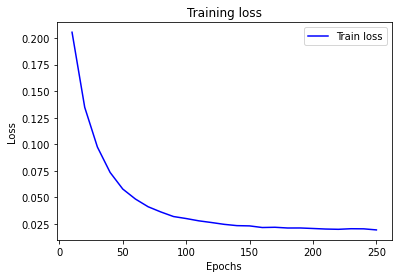

In [ ]:
plot_loss(train_loss_all)

After the model is trained, we use it to translate a few English sentences into French, and compute their BLEU scores. The `predict_seq2seq()` and `bleu()` functions are the same as in *Laboratory 5*.

In [ ]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """Predict for sequence to sequence."""
    # Set `net` to eval mode for inference
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # Add the batch axis
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # Add the batch axis
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # We use the token with the highest prediction likelihood as the input
        # of the decoder at the next time step
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # Save attention weights
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # Once the end-of-sequence token is predicted, the generation of the
        # output sequence is complete
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

In [ ]:
def bleu(pred_seq, label_seq, k):
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [ ]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est mort !,  bleu 0.537
i'm home . => je suis chez moi .,  bleu 1.000


By visualizing the attention weights when translating the last English sentence,
we can see that each query assigns non-uniform weights over key-value pairs. It shows that, at each decoding step, different parts of the input sequences are selectively aggregated in the attention pooling.

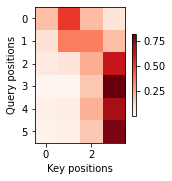

In [ ]:
attention_weights = torch.cat([step[0][0][0] for step in dec_attention_weight_seq], 0).reshape((
    1, 1, -1, num_steps))
# Plus one to include the end-of-sequence token
show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')

# Multi-head attention

In our implementation of *multi-head attention*, we choose the scaled dot-product attention for each head of the multi-head attention. To avoid significant growth of computational cost and parameterization cost, we set $p_q = p_k = p_v = p_o / h$. Note that the $h$ heads can be computed in parallel if we set the number of outputs of linear transformations for the query, key, and value to $p_q h = p_k h = p_v h = p_o$. In the following implementation, $p_o$ is specified via the argument `num_hiddens`.

To allow for parallel computation of multiple heads, the `MultiHeadAttention` class uses two transposition functions as defined below. Specifically, the `transpose_output()` function reverses the operation of the `transpose_qkv()` function.

In [ ]:
def transpose_qkv(X, num_heads):
    """Transposition for parallel computation of multiple attention heads."""
    # Shape of input `X` is:
    # (`batch_size`, no. of queries or key-value pairs, `num_hiddens`).
    # Shape of output `X` is:
    # (`batch_size`, no. of queries or key-value pairs, `num_heads`,
    # `num_hiddens` / `num_heads`)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # Shape of output `X` is:
    # (`batch_size`, `num_heads`, no. of queries or key-value pairs,
    # `num_hiddens` / `num_heads`)
    X = X.permute(0, 2, 1, 3)

    # Shape of `output` is:
    # (`batch_size` * `num_heads`, no. of queries or key-value pairs,
    # `num_hiddens` / `num_heads`)
    return X.reshape(-1, X.shape[2], X.shape[3])

def transpose_output(X, num_heads):
    """Reverse the operation of `transpose_qkv`."""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [ ]:
class MultiHeadAttention(nn.Module):
    """Multi-head attention."""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # Shape of `queries`, `keys`, or `values` is:
        # (`batch_size`, no. of queries or key-value pairs, `num_hiddens`)
        # Shape of `valid_lens` is:
        # (`batch_size`,) or (`batch_size`, no. of queries)
        # After transposing, shape of output `queries`, `keys`, or `values` is:
        # (`batch_size` * `num_heads`, no. of queries or key-value pairs,
        # `num_hiddens` / `num_heads`)
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            # On axis 0, copy the first item (scalar or vector) for
            # `num_heads` times, then copy the next item, and so on
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        # Shape of `output` is: (`batch_size` * `num_heads`, no. of queries,
        # `num_hiddens` / `num_heads`)
        output = self.attention(queries, keys, values, valid_lens)

        # Shape of `output_concat` is:
        # (`batch_size`, no. of queries, `num_hiddens`)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

Let us test our implemented `MultiHeadAttention` class using a toy example, where keys and values are the same. As a result, the shape of the multi-head attention output is (`batch_size`, `num_queries`, `num_hiddens`).

In [ ]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                               num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [ ]:
batch_size, num_queries, num_kvpairs, valid_lens = 2, 4, 6, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens).shape

torch.Size([2, 4, 100])

# Self-attention and positional encoding

Using multi-head attention, the following code snippet computes the *self-attention* of a tensor with shape (batch size, number of time steps or sequence length in tokens, $d$). The output tensor has the same shape.

In [ ]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                               num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [ ]:
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
attention(X, X, X, valid_lens).shape

torch.Size([2, 4, 100])

Suppose that the input representation $\boldsymbol{X} \in \mathbb{R}^{n \times d}$ contains the $d$-dimensional embeddings for $n$ tokens of a sequence. The *positional encoding* outputs $\boldsymbol{X} + \boldsymbol{P}$ using a positional embedding matrix $\mathbf{P} \in \mathbb{R}^{n \times d}$ of the same shape, whose element on the $i$th row and the $(2j)$th or the $(2j + 1)$th column is:

$$\begin{aligned} p_{i, 2j} &= \sin\left(\frac{i}{10000^{2j/d}}\right),\\p_{i, 2j+1} &= \cos\left(\frac{i}{10000^{2j/d}}\right).\end{aligned}$$

At first glance, this trigonometric-function design looks weird. Before explanations of this design, let us first implement it in the following `PositionalEncoding` class.

In [ ]:
class PositionalEncoding(nn.Module):
    """Positional encoding."""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough `P`
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

In the positional embedding matrix $\boldsymbol{P}$, rows correspond to positions within a sequence and columns represent different positional encoding dimensions. In the example below, we can see that the $6$th and the $7$th columns of the positional embedding matrix have a higher frequency than the $8$th and the $9$th columns. The offset between the $6$th and the $7$th (same for the $8$th and the $9$th) columns is due to the alternation of sine and cosine functions.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2318.)
  import sys


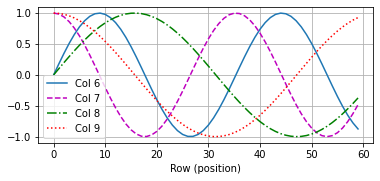

In [ ]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
pos_encoding.eval()
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
plt.figure(figsize=(6, 2.5))
plt.plot(torch.arange(num_steps), P[0, :, 6].T, '-', label="Col 6")
plt.plot(torch.arange(num_steps), P[0, :, 7].T, 'm--', label="Col 7")
plt.plot(torch.arange(num_steps), P[0, :, 8].T, 'g-.', label="Col 8")
plt.plot(torch.arange(num_steps), P[0, :, 9].T, 'r:', label="Col 9")
plt.xlabel('Row (position)')
plt.legend()
plt.grid(True)
plt.show()

To see how the monotonically decreased frequency along the encoding dimension relates to absolute positional information, let us print out the binary representations of $0, 1, \ldots, 7$. As we can see, the lowest bit, the second-lowest bit, and the third-lowest bit alternate on every number, every two numbers, and every four numbers, respectively.

In [ ]:
for i in range(8):
    print(f'{i} in binary is {i:>03b}')

0 in binary is 000
1 in binary is 001
2 in binary is 010
3 in binary is 011
4 in binary is 100
5 in binary is 101
6 in binary is 110
7 in binary is 111


In binary representations, a higher bit has a lower frequency than a lower bit. Similarly, as demonstrated in the heat map below, the positional encoding decreases frequencies along the encoding dimension by using trigonometric functions. Since the outputs are float numbers, such continuous representations are more space-efficient than binary representations.

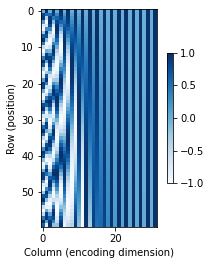

In [ ]:
P = P[0, :, :].unsqueeze(0).unsqueeze(0)
show_heatmaps(P, xlabel='Column (encoding dimension)',
              ylabel='Row (position)', figsize=(3.5, 4), cmap='Blues')

#Transformer

We have already implemented multi-head attention based on scaled dot-products and positional encoding above. In the following, we will implement the rest of the *transformer* model.

The position-wise feed-forward network transforms the representation at all the sequence positions using the same MLP. This is why we call it *position-wise*. In the implementation below, the input `X` with shape (batch size, number of time steps or sequence length in tokens, number of hidden units or feature dimension) will be transformed by a two-layer MLP into an output tensor of shape
(batch size, number of time steps, `ffn_num_outputs`).

In [ ]:
class PositionWiseFFN(nn.Module):
    """Position-wise feed-forward network."""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

The following example shows that the innermost dimension of a tensor changes to
the number of outputs in the position-wise feed-forward network. Since the same MLP transforms at all the positions, when the inputs at all these positions are the same, their outputs are also identical.

In [ ]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

tensor([[ 0.3745,  0.0313, -0.0469, -0.2155,  0.6962, -0.0252,  0.1524,  0.2927],
        [ 0.3745,  0.0313, -0.0469, -0.2155,  0.6962, -0.0252,  0.1524,  0.2927],
        [ 0.3745,  0.0313, -0.0469, -0.2155,  0.6962, -0.0252,  0.1524,  0.2927]],
       grad_fn=<SelectBackward0>)

Now, let us focus on the "Add & norm" component. This is a residual connection immediately followed by layer normalization. Both are key to effective deep architectures.

Layer normalization is the same as batch normalization, except that the former normalizes across the feature dimension. Despite its pervasive applications
in computer vision, batch normalization is usually empirically less effective than layer normalization in natural language processing tasks, whose inputs are often variable-length sequences.

The following code snippet compares the normalization across different dimensions by layer normalization and batch normalization, respectively.

In [ ]:
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# Compute mean and variance from `X` in the training mode
print('Layer norm:', ln(X), '\nBatch norm:', bn(X))

Layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
Batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


Now, we can implement the `AddNorm` class using a residual connection followed by layer normalization. Dropout is also applied for regularization.

In [ ]:
class AddNorm(nn.Module):
    """Residual connection followed by layer normalization."""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

The residual connection requires that the two inputs are of the same shape, so that the output tensor also has the same shape after the addition operation.

In [ ]:
add_norm = AddNorm([3, 4], 0.5) # `normalized_shape` is input.size()[1:]
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

With all the essential components to assemble the transformer encoder, let us start by implementing a single layer within the encoder. The following `EncoderBlock` class contains two sublayers: multi-head self-attention and position-wise feed-forward networks, where a residual connection followed by layer normalization is employed around both sublayers.

In [ ]:
class EncoderBlock(nn.Module):
    """Transformer encoder block."""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout,
            use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

As we can see, any layer in the transformer encoder does not change the shape of its input.

In [ ]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

In the following transformer encoder implementation, we stack `num_layers` instances of the above `EncoderBlock` classes. Since we use the fixed positional encoding whose values are always between $-1$ and $1$, we multiply values of the learnable input embeddings by the square root of the embedding dimension to rescale before summing up the input embedding and the positional encoding.

In [ ]:
class TransformerEncoder(Encoder):
    """Transformer encoder."""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

Below we specify hyperparameters to create a two-layer transformer encoder. The shape of the transformer encoder output is (batch size, number of time steps, `num_hiddens`).

In [ ]:
encoder = TransformerEncoder(
    200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

The transformer decoder is also composed of multiple identical layers. Each layer is implemented in the following `DecoderBlock` class, which contains three sublayers: decoder self-attention, encoder-decoder attention, and position-wise feed-forward networks. These sublayers employ a residual connection around them, followed by layer normalization.

In the masked multi-head decoder self-attention (the first sublayer), queries, keys, and values all come from the outputs of the previous decoder layer. When training sequence-to-sequence models, tokens at all the positions (time steps) of the output sequence are known. However, during prediction, the output sequence is generated token by token; thus, at any decoder time step, only the generated tokens can be used in the decoder self-attention. To preserve auto-regression in the decoder, its masked self-attention specifies `dec_valid_lens`, so that any query only attends to all positions in the decoder up to the query position.

In [ ]:
class DecoderBlock(nn.Module):
    # The `i`-th block in the decoder
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so `state[2][self.i]` is `None` as initialized.
        # When decoding any output sequence token by token during prediction,
        # `state[2][self.i]` contains representations of the decoded output at
        # the `i`-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # Shape of `dec_valid_lens` is: (`batch_size`, `num_steps`), where
            # every row is [1, 2, ..., `num_steps`]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None

        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # Encoder-decoder attention. Shape of `enc_outputs` is:
        # (`batch_size`, `num_steps`, `num_hiddens`)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

To facilitate scaled dot-product operations in the encoder-decoder attention and addition operations in the residual connections, the feature dimension (`num_hiddens`) of the decoder is the same as that of the encoder.

In [ ]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

Now, we construct the entire transformer decoder composed of `num_layers` instances of `DecoderBlock`. In the end, a fully-connected layer computes the prediction for all the `vocab_size` possible output tokens. Both of the decoder self-attention weights and the encoder-decoder attention weights are stored for later visualization.

In [ ]:
class TransformerDecoder(AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

Let us instantiate an encoder-decoder model by following the transformer architecture. Here, we specify that both the transformer encoder and the transformer decoder have $2$ layers using $4$-head attention. We train the transformer model for sequence to sequence learning on the English-French machine translation dataset.

In [ ]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = EncoderDecoder(encoder, decoder)
train_loss_all = train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device) #1 min

loss 0.031, device cpu


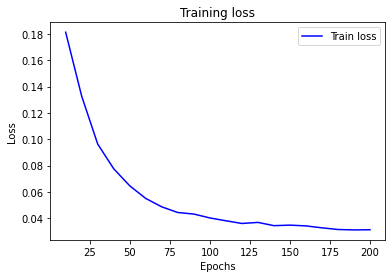

In [ ]:
plot_loss(train_loss_all)

After training, we use the transformer model to translate a few English sentences into French, and compute their BLEU scores.

In [ ]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est calme .,  bleu 1.000
i'm home . => je suis chez moi .,  bleu 1.000


Let us visualize the transformer attention weights when translating the last English sentence into French. The shape of the encoder self-attention weights is (number of encoder layers, number of attention heads, `num_steps` or number of queries, `num_steps` or number of key-value pairs).

In [ ]:
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads,
    -1, num_steps))
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

In the encoder self-attention, both queries and keys come from the same input sequence. Since padding tokens do not carry meaning, with specified valid length of the input sequence, no query attends to positions of padding tokens.
In the following, two layers of multi-head attention weights are presented row by row. Each head independently attends based on a separate representation subspaces of queries, keys, and values.

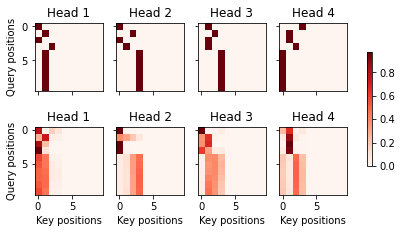

In [ ]:
show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))